In [2]:
import pandas as pd
import numpy as np
import random
from matplotlib import pyplot as plt
from scipy.integrate import quad
import scipy.stats
from time import time

In [3]:
class InterestRate():
    # The most usefull interest rates
    def __init__(self):
        EONIA = -0.467
        ESTER = -0.467
        EURIBOR = {"1W":-0.530, "1M":-0.515, "3M":-0.481, "6M":-0.443, "1Y":-0.373}
        LIBOR = {"1W":-0.56371, "1M":-0.54414, "3M":-0.51657, "6M":-0.46471, "1Y":-0.36643}

In [91]:
class ZeroCoupon(InterestRate):
    #zero coupon price and rate
    def __init__(self, time_spot, maturity):
        self.t = time_spot
        self.T = maturity
    
    def discountfactor(self, zc_rate,t=None, T=None):
        # Price today of 1euro owned at a future date T
        if t==None:
            t=self.t
        if T== None:
            T=self.T
        return pow(1+zc_rate/100,t-T)
    
    def zcrate(self, discount_factor, t=None, T=None):
        #Yiel of an investment until T without coupons
        if t==None:
            t=self.t
        if T== None:
            T=self.T
        return pow(discount_factor,1/(t-T))-1
    
    def forwardrate(self, time_zero, t, discount_factor_T0, discount_factor_T1, maturity):
        #Rate applicable at a future date
        return pow(self.zcrate(discount_factor_T1, t, maturity)/self.zcrate(discount_factor_T0, time_zero, t), 1/(maturity-time_zero))-1

In [301]:
#Exemple
zc = ZeroCoupon(0,1)
print(zc.discountfactor(5,0,1)*(1+5/100))
print(zc.zcrate(1,0,1))
print(zc.forwardrate(0,1,-0.5,-0.2,2))

1.0
0.0
0.41421356237309515


In [190]:
class Bond(ZeroCoupon):
    #Simple bond
    
    def __init__(self, time_spot, nominal, maturity, rate, freq_payement, market_price):
        self.t = time_spot
        self.N = nominal
        self.T = maturity
        self.r = rate
        self.freq_payement = freq_payement
        self.market_price = market_price
    
    def datecashflow(self,date_begin, date_end, freq_payement):
        #return number of day of the bond. to complet for having the exat number of days, to correct if the end is not a buisness day etc
        payement_date = []
        if freq_payement == 1:
            begin = [int(x) for x in date_begin.split("/")]
            end = [int(x) for x in date_end.split("/")]
            p=dt.date(begin[2],begin[1],begin[0])
            start_y = begin[2]
            while p < dt.date(end[2],end[1],end[0]):
                payement_date.append("/".join([str(p.day), str(p.month), str(p.year)]))
                start_y+=1
                p = dt.date(start_y,begin[1],begin[0])

        else :
            begin = [int(x) for x in date_begin.split("/")]
            end = [int(x) for x in date_end.split("/")]
            p=dt.date(begin[2],begin[1],begin[0])
            start_y = begin[2]
            start_m = begin[1]
            while p < dt.date(end[2],end[1],end[0]):
                payement_date.append("/".join([str(p.day), str(p.month), str(p.year)]))
                if start_m + int(12/freq_payement) <= 12:
                    start_m += int(12/freq_payement)
                    p = dt.date(start_y,start_m,begin[0])
                else:
                    start_m = int(12/freq_payement)-(12-start_m)
                    start_y += 1
                    print(start_m)
                    p = dt.date(start_y,start_m,begin[0])

        return payement_date
    
    def bondvalue(self, zc_rates):
        #takes the actuarial rates and returns a tuple withe the bond value in first position and a list of cashflow discounted in second position.
        value = 0
        cashflow_discounted = []
        for i in range(self.t, self.T, self.freq_payement):
            cashflow_discounted.append((self.N*self.r/100)*self.discountfactor(zc_rates[i], self.t, self.t+i))
            value += (self.N*self.r/100)*self.discountfactor(zc_rates[i], self.t, self.t+i)
        value += self.discountfactor(zc_rates[-1], self.t, self.T)*self.N
        cashflow_discounted.append(self.discountfactor(zc_rates[-1], self.t, self.T)*self.N)
        
        return (value, cashflow_discounted)
    
    def yieldtomaturity(self):
        #return the yield to maturity of the bond ()
        YTM = 0
        x=0
        y=100
        for i in range(100):
            YTM = 0.5*(x+y)
            if self.market_price>self.bondvalue([YTM]*(self.T - self.t)*self.freq_payement)[0]:
                y=YTM
            else:
                x=YTM
        z= (x+y)/2
        return z

In [191]:
#Exemple
Obligation = Bond(0,100,5,4,1,100.71229157296257)
Obligation.bondvalue([4]*10)

(100.71229157296257,
 [4.0,
  3.846153846153846,
  3.6982248520710055,
  3.555985434683659,
  3.419216764118903,
  82.19271067593516])

In [298]:
class YieldCurve(Bond):
    #plot yield curve by bootstrapping
    
    def __init__(self, list_of_bonds, yields):
        self.list_of_bonds = list_of_bonds
        self.yields = yields
    
    def get_yields(self):
        iterator = []
        for m in self.list_of_bonds:
            iterator.append(m["maturity"])
        for T in iterator: 
            if T in self.yields.keys():
                next
            else:
                i=0
                while self.list_of_bonds[i]["maturity"]!=T:
                    i+=1
                bond = self.list_of_bonds[i]
                mty = [i for i in range(1,round(float(T[:-1])+1))]
                residual_month = float(T[:-1]) - round(float(T[:-1]))
                y = bond["price"]
                for m in mty[:-1]:
                    y = y - (bond["coupon"]/pow((1+self.yields[str(m)+"Y"]),m))
                y =pow((100+bond["coupon"])/y, 1/float(T[:-1])) - 1
                self.yields[T] = y      
        plt.plot(list(self.yields.values()))
        return self.yields

{'1W': -0.56371, '1M': -0.54414, '3M': -0.51657, '6M': -0.46471, '1Y': -0.36643, '1.2Y': 0.010435940952064682, '1.9Y': 0.07415079810003422, '2Y': 0.07779903922058451, '2.6Y': 0.07056238754333655, '3Y': 0.06535854045151979}


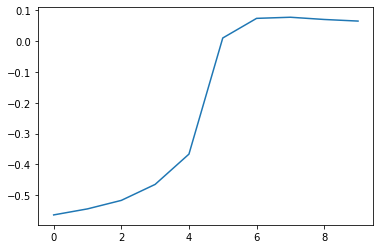

In [300]:
#Exemple
bonds = [{"maturity":"1.2Y", "coupon":5, "price":103.7}, {"maturity":"1.9Y", "coupon":6, "price":102},
        {"maturity":"2Y", "coupon":5.5, "price":99.5}, {"maturity":"2.6Y", "coupon":4.5, "price":98.5},
        {"maturity":"3Y", "coupon":3, "price":92.5}]
yields = {"1W":-0.56371, "1M":-0.54414, "3M":-0.51657, "6M":-0.46471, "1Y":-0.36643}

curve = YieldCurve(bonds, yields)
yieldsss = curve.get_yields()
print(yieldsss)

In [507]:
class Swap():
    
    def __init__(self, begin_period, end_period, freq_pay_fix, freq_pay_float, fixing, discount,rate_forward):
        self.begin_period = begin_period
        self.end_period = end_period
        self.fix = fixing
        self.dis = discount
        self.rate_forward = rate_forward #dict avec cle : Ti, valeur : taux forward en date de payement Ti vu en Ti-1
        self.freq_pay_fix= freq_pay_fix
        self.freq_pay_var = freq_pay_float
        self.float_payement_date = self.datecashflow(begin_period, end_period, freq_pay_float)
        self.fix_payement_date = self.datecashflow(begin_period,end_period,freq_pay_fix)
    

        
    def datecashflow(self, date_begin, date_end, freq_payement):
        #return number of day of the swap (whitout considering 30/360 ...). to complet for having the exat number of days, to correct if the end is not a buisness day etc
        payement_date = []
        if freq_payement == 1:
            begin = [int(x) for x in date_begin.split("/")]
            end = [int(x) for x in date_end.split("/")]
            p=dt.date(begin[2],begin[1],begin[0])
            start_y = begin[2]
            while p <= dt.date(end[2],end[1],end[0]):
                payement_date.append("/".join([str(p.day), str(p.month), str(p.year)]))
                start_y+=1
                p = dt.date(start_y,begin[1],begin[0])

        else :
            begin = [int(x) for x in date_begin.split("/")]
            end = [int(x) for x in date_end.split("/")]
            p=dt.date(begin[2],begin[1],begin[0])
            start_y = begin[2]
            start_m = begin[1]
            while p <= dt.date(end[2],end[1],end[0]):
                payement_date.append("/".join([str(p.day), str(p.month), str(p.year)]))
                if start_m + int(12/freq_payement) <= 12:
                    start_m += int(12/freq_payement)
                    p = dt.date(start_y,start_m,begin[0])
                else:
                    start_m = int(12/freq_payement)-(12-start_m)
                    start_y += 1
                    p = dt.date(start_y,start_m,begin[0])

        return payement_date
    
    def nbdays(self,date_begin, date_end):
        date_begin = [int(x) for x in date_begin.split("/")]
        date_end = [int(x) for x in date_end.split("/")]

        return (dt.date(date_end[2],date_end[1], date_end[0]) - dt.date(date_begin[2], date_begin[1], date_begin[0])).days

    def swaprate(self):
        a = 0
        b = 0
        for k in range(len(self.float_payement_date)-1):
            a += self.rate_forward[k]*self.nbdays(self.float_payement_date[k], self.float_payement_date[k+1])*self.dis[k]
        for i in range(len(self.fix_payement_date)-1):
            b += self.nbdays(self.fix_payement_date[i], self.fix_payement_date[i+1])*self.dis[i]
        
        return a/b
            
            
    

In [508]:
#Exemple
discount = [0.999665144, 0.999414583, 0.999146461, 0.998848562]
TxFwd = [0.227,0.2394,0.2598,0.2824]
monswap = Swap('27/11/2013','27/11/2014', 1, 4, 0,discount,TxFwd)
monswap.swaprate()

0.2521480425816344